<img src='./img/DataStore_EUMETSAT_Copernicus.png'/>

Copyright (c) 2022 EUMETSAT <br>
License: MIT

<hr>

<a href="./index.ipynb">← Index</a>
<br>
<a href="./3_Downloading_products.ipynb">← Downloading products</a><span style="float:right;">

# Sentinel-3 Data Store access with EUMDAC

### Data used

| Product Description  | Data Store collection ID| Product Navigator |
|:--------------------:|:-----------------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution  | EO:EUM:DAT:0407 | [link](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced) |

### Learning outcomes

At the end of this notebook you will know;
* How to refine your <font color="#138D75">**searches**</font> for Sentinel-3 products in the EUMETSAT Data Store using the `eumdac` API client
* How to <font color="#138D75">**download**</font> components of products
* How to pre-screen downloads based on flags

### Outline

Data from Sentinel-3 is available through multiple sources, either via a web user interface (WebUI) or through code and command line interfaces with an Application Programming Interface (API). WebUIs are useful for accessing quick-look data visualisations, and for browsing to see what is available. APIs are more useful for routine, automated and operational data access. Here we will guide you through ways you can access Sentinel-3 data through both methods. We will use OLCI Level-2 Full Resolution data as an example.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

1. [Download data via GUIs](#section1)
1. [Authenticating the APIs](#section2)
1. [Example 1: Filter by collections](#section3)
1. [Example 2: Filter by time](#section4)
1. [Example 3: Filter by space and time](#section5)
1. [Example 4: Download by component](#section6)

<hr>

In [1]:
import os
import json
import datetime
import shutil
import eumdac
from IPython.display import YouTubeVideo, HTML

# Create a download directory for our downloaded products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Downloading data via GUIs
[Back to top](#TOC_TOP)

</div>

### The EUMETSAT Data Store

The [Data Store](https://data.eumetsat.int) is EUMETSAT's primary pull service for delivering data, including the ocean data available from Sentinel-3. 

Access to it is possible through a WebUI, and through a series of application programming interfaces (APIs). The Data Store supports browsing, searching and downloading data as well as subscription services. It also provides a link to the online version of the [EUMETSAT Data Tailor](https://tailor.eumetsat.int/) for customisation. The video below provides an overview of the Data Store WebUI.

The video below explains how you can access data through the EUMETSAT Data Store WebUI. You can visit and see if you can find Sentinel-3 data to download, however this notebook will also show you how to access the Data Store API, facilitated by the `eumdac` client (see the [Downloading via the Data Store API](#section3) section, below).
#### Links:

* [EUMETSAT Data Store](https://data.eumetsat.int)
* [More information on the Data Store](https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview)

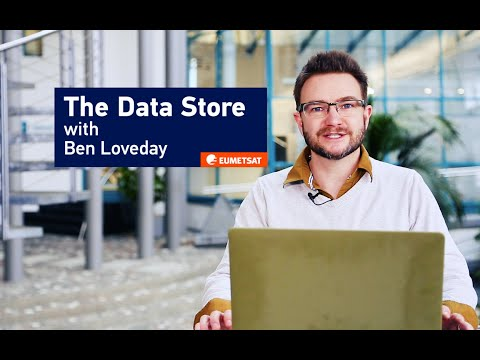

In [2]:
YouTubeVideo('WINakzAZvxw', width=700, height=450)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Authenticating the APIs
[Back to top](#TOC_TOP)

</div>

To access Sentinel-3 data from the [Data Store](https://data.eumetsat.int), we will use the EUMETSAT Data Access Client (`eumdac`). If you are working with the recommended Anaconda Python distribution, you can install eumdac using;

`conda install -c eumetsat eumdac`

However, you can also find the source code on the [EUMETSAT gitlab](https://gitlab.eumetsat.int/eumetlab/data-services/eumdac). Please visit the EUMETSAT user support confluence spaces for the the [Data Store](https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview) and [eumdac](https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/overview) for more information.

In order to allow us to download data from the Data Store via API, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumdac_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

#### Option 1: creating  `.eumdac_credentials` in our home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"consumer_key": "<your_consumer_key>",
"consumer_secret": "<your_consumer_secret>"
}
```

You must replace `<your_consumer_key>` and `<your_consumer_secret>` with the information you extract from https://api.eumetsat.int/api-key/. You will need a [EUMETSAT Earth Observation Portal account](https://eoportal.eumetsat.int/) to access this link, and in order to see the information you must click the "Show hidden fields" button at the bottom of the page.

*Note: your key and secret are permanent, so you only need to do this once, but you should take care to never share them*

Once you have done this, you can read in your credentials using the commands in the following cell. These will be used to generate a time-limited token, which will refresh itself when it expires.

In [ ]:
# load credentials
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

#### Option 2: provide credentials directly

You can provide your credentials directly as follows;

`token = eumdac.AccessToken((consumer_key, consumer_secret))`

Once we have a token (by either method described above) we can create a datastore 'object' that contains all the collections, and filter this list for those that are relevant to Sentinel-3. The code to the right of the colon is what will tell use the ID for the Sentinel-3 collection we are interested in.

*Note: this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.*


In [ ]:
# create data store object
datastore = eumdac.DataStore(token)

# show all collections:
for collectionID in datastore.collections:
    if 'Sentinel-3' in collectionID.title:
        print(f"{collectionID}: {collectionID.title}")

Now we can select our collection of interest, which in this case is EO:EUM:DAT:0407 for OLCI Level 2 Ocean Colour Full Resolution.

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Example 1: Filtering by collection
[Back to top](#TOC_TOP)

</div>

Now that we know out collection of interest, we can use `eumdac` to create collection object

In [ ]:
# set collection ID for OLCI L2 WFR
collectionID = 'EO:EUM:DAT:0407'

# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(selected_collection.title)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>Example 2: Filtering by time
[Back to top](#TOC_TOP)

</div>

Now that we specified our collection, we can query the collections it contains. For example, to find the lastest product in a collection;

In [ ]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()
print(latest)

Alternatively, we can search for and list all the products that occur within a time range.

In [ ]:
# time filter the collection for products
start = datetime.datetime(2022, 3, 23, 16, 0)
end = datetime.datetime(2022, 3, 23, 16, 15)
products = selected_collection.search(dtstart=start, dtend=end)

for product in products:
    print(product)

<div class="alert alert-info" role="alert">

## <a id='section3'></a>Example 3: Filtering by space and time
[Back to top](#TOC_TOP)

</div>

Alongside temporal filtering, we can also pass "Well Known Text (WKT)" polygons to `eumdac` to specify a region of interest (ROI) that we want to search over.

In [ ]:
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)
start = datetime.datetime(2022, 1, 23)
end = datetime.datetime(2022, 1, 24)
roi = [[-1.0, -1.0], [4.0, -4.0], [8.0, -2.0], [9.0, 2.0], [6.0, 4.0], [1.0, 5.0], [-1.0, -1.0]]
WKT = 'POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi]))

products = selected_collection.search(
    geo=WKT,
    dtstart=start, 
    dtend=end)

for product in products:
    print(product)

<div class="alert alert-info" role="alert">

## <a id='section4'></a>Example 4: Downloading entire products
[Back to top](#TOC_TOP)

</div>

Once we have identified a product, we can download it simply by passing the product and collectionID to the `get_product` method of our `datastore` object.

In [ ]:
selected_product = datastore.get_product(product_id=str(product), collection_id=collectionID)

with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
    print(f'Downloading {fsrc.name}')
    shutil.copyfileobj(fsrc, fdst)
    print(f'Download of product {fsrc.name} finished.')

<div class="alert alert-info" role="alert">

## <a id='section4'></a>Example 5: Downloading by component
[Back to top](#TOC_TOP)

</div>

If we do not wish to download an entire product, we can choose to select only a single component using the `entries` property of the product.

In [ ]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()

for entry in latest.entries:
    if 'xfdumanifest.xml' in entry:
        with latest.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name),
                                                    mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

<a href="./index.ipynb">← Index</a>
<br>
<a href="./3_Downloading_products.ipynb">← Downloading products</a><span style="float:right;">

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE.txt">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/data-services/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact</a></span></p>